In [1]:
import time
from collections.abc import Callable, Generator

import datasets
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F  # noqa: N812
from tokenizers import Tokenizer, decoders, normalizers
from tokenizers.models import WordPiece
from tokenizers.normalizers import NFD, Lowercase
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from tokenizers.trainers import WordPieceTrainer
from torch import Tensor, nn
from tqdm import tqdm


/Users/nivanov/miniconda3/envs/dlmetal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this notebook, we train a neural translation model based on transformer architecture.
We use a bigger dataset than in the previous RNN notebook. The new dataset consists of around 200k training examples (German to English translation pairs). We will also use BERT tokenizer to build vocabulary instead of using our own language class.

### Data processing

In [2]:
PARENT_DIR = "."

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # for Apple chips
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


We load IWSLT dataset that contains pairs of German-English translations. Train data has around 200k rows which is suitable for the small model that we'll build.

In [4]:
dataset = datasets.load_dataset("IWSLT/iwslt2017", "iwslt2017-de-en", trust_remote_code=True)

In [5]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

MAX_NUM_SAMPLES = None
if MAX_NUM_SAMPLES is not None:
    train_data = train_data.take(MAX_NUM_SAMPLES)

In [6]:
train_data[0]

{'translation': {'de': 'Vielen Dank, Chris.',
  'en': 'Thank you so much, Chris.'}}

We now fit our tokenizers to the language corpus. We create two tokenizers: one for German (`src_lang`) and one for English (`tgt_lang`). One could also create a single tokenizer and train it on both languages (multilingual). This approach is frequently used in practice but most likely requires bigger models than the one we will build below. Hence, we opt for two separate tokenizers.

Code below will train new tokenizers and save them. Alternatively, you can just run last two lines to download pre-trained tokenizer.

In [23]:
def craete_tokenizer(max_vocab_size: int = 8000) -> tuple[Tokenizer, WordPieceTrainer]:
    tokenizer = Tokenizer(WordPiece(unk_token="<UNK>"))  # noqa: S106
    tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase()])
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.post_processor = TemplateProcessing(
        single="<BOS> $A <EOS>",
        special_tokens=[
            ("<BOS>", 1),
            ("<EOS>", 2),
        ],
    )
    tokenizer.decoder = decoders.WordPiece()
    trainer = WordPieceTrainer(vocab_size=max_vocab_size,
                               special_tokens=["<UNK>", "<BOS>", "<EOS>", "<PAD>"])

    return tokenizer, trainer

def batch_iterator(batch_size: int, data: datasets.Dataset, key: str) -> Generator[str]:
    for i in range(0, len(data), batch_size):
        data_batch = data[i : i + batch_size]["translation"]
        data_key = [x[key] for x in data_batch]
        yield data_key

src_lang, src_lang_trainer = craete_tokenizer()
tgt_lang, tgt_lang_trainer = craete_tokenizer()

src_lang.train_from_iterator(batch_iterator(256, train_data, "de"), src_lang_trainer)
tgt_lang.train_from_iterator(batch_iterator(256, train_data, "en"), tgt_lang_trainer)

src_lang.save(f"{PARENT_DIR}/de_tokenizer")
tgt_lang.save(f"{PARENT_DIR}/en_tokenizer")

src_lang = Tokenizer.from_file(f"{PARENT_DIR}/de_tokenizer")
tgt_lang = Tokenizer.from_file(f"{PARENT_DIR}/en_tokenizer")

In [10]:
def tokenize_example(example: dict[str, str],
                     en_tokenizer: Tokenizer,
                     de_tokenizer: Tokenizer,
                     max_length: int) -> dict[str, list[str | int]]:
    en_encoded = en_tokenizer.encode(example["translation"]["en"])
    de_encoded = de_tokenizer.encode(example["translation"]["de"])

    return {"en_tokens": en_encoded.tokens[:max_length],
            "de_tokens": de_encoded.tokens[:max_length],
            "en_ids": en_encoded.ids[:max_length],
            "de_ids": de_encoded.ids[:max_length]}

max_length = 128
sos_token = "<BOS>"  # noqa: S105
eos_token = "<EOS>"  # noqa: S105

fn_kwargs = {
    "en_tokenizer": tgt_lang,
    "de_tokenizer": src_lang,
    "max_length": max_length,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

# train_data.save_to_disk(f"{PARENT_DIR}/train_data_{max_length}")
# valid_data.save_to_disk(f"{PARENT_DIR}/valid_data_{max_length}")
# test_data.save_to_disk(f"{PARENT_DIR}/test_data_{max_length}")

# train_data = datasets.load_from_disk(f"{PARENT_DIR}/train_data_{max_length}")
# valid_data = datasets.load_from_disk(f"{PARENT_DIR}/valid_data_{max_length}")
# test_data = datasets.load_from_disk(f"{PARENT_DIR}/test_data_{max_length}")

Map: 100%|██████████| 8079/8079 [00:00<00:00, 9434.77 examples/s]


In [9]:
print(f"Vocab size src: {src_lang.get_vocab_size()}")
print(f"Vocab size tgt: {tgt_lang.get_vocab_size()}")

Vocab size src: 8000
Vocab size tgt: 8000


In [10]:
print(src_lang.decode(train_data[2]["de_ids"]))
print(tgt_lang.decode(train_data[2]["en_ids"]))

ich bin wirklich begeistert von dieser konferenz, und ich danke ihnen allen für die vielen netten kommentare zu meiner rede vorgestern abend.
i have been blown away by this conference, and i want to thank all of you for the many nice comments about what i had to say the other night.


In [11]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True,
    )

valid_data = valid_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True,
)

In [12]:
def get_collate_fn(pad_index: int) -> Callable[[dict], dict]:
    def collate_fn(batch: dict) -> dict[str, int]:
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        return {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }

    return collate_fn

def get_data_loader(dataset: datasets.Dataset, batch_size: int, pad_index: int, *,
                    shuffle: bool = True, pin_memory: bool = False) -> torch.utils.data.DataLoader:
    collate_fn = get_collate_fn(pad_index)
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
        pin_memory=pin_memory,
    )

batch_size = 64

train_data_loader = get_data_loader(train_data, batch_size, tgt_lang.token_to_id("<PAD>"))
valid_data_loader = get_data_loader(valid_data, batch_size, tgt_lang.token_to_id("<PAD>"))
test_data_loader = get_data_loader(test_data, batch_size, tgt_lang.token_to_id("<PAD>"))

### Model

We build a transformer model from scratch closely following the paper [Attention is all you need](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). The main difference is that in the paper they used sine and cosine positional embeddings. In the implementation below we will learn positional embeddings instead (this is a standard approach nowadays).

We start with `MultiHeadAttention` implementation which is the core of the transformer's architecture. We then add other layers to form `Encoder` and `Decoder` classes. Finally, we wrap everything up into the `TranslatorModel` class.

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int, dropout_ratio: float = 0.1):
        if hidden_dim % num_heads != 0:
            msg = "hidden_dim must be divisible by num_heads"
            raise ValueError(msg)

        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)

        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

        self.scaling = 1 / (self.head_dim ** .5)

    def forward(self, q: Tensor, k: Tensor, v: Tensor, mask: Tensor = None) -> Tensor:
        """
        Inputs
            q: query of size (batch_size, seq_length, hidden_dim)
            k: query of size (batch_size, seq_length, hidden_dim)
            v: query of size (batch_size, seq_length, hidden_dim)
            mask: optional mask of size (batch_size, 1, 1, seq_length)
                  or (batch_size, 1, seq_length, seq_length)
        Outputs
            attention weighted embedding vectors of size (batch_size, seq_length, hidden_dim)
        """
        # all Q, K, V are of shape (batch_size, seq_length, hidden_dim)
        Q = self.fc_q(q)
        K = self.fc_k(k)
        V = self.fc_v(v)

        batch_size, seq_length, _ = Q.size()

        # all Q, K, V are of shape (batch_size, num_heads, seq_length, head_dim)
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # energy.shape (batch_size, num_heads, seq_length, seq_length)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) * self.scaling  # type: Tensor

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -torch.inf)

        # attention.shape (batch_size, num_heads, seq_length, seq_length)
        attention = energy.softmax(dim=-1)
        attention = self.dropout(attention)

        # x.shape (batch_size, num_heads, seq_length, head_dim)
        x = torch.matmul(attention, V)

        # x.shape (batch_size, seq_length, num_heads, head_dim)
        x = x.permute(0, 2, 1, 3)

        # x.shape (batch_size, seq_length, hidden_dim)
        x = x.reshape(batch_size, seq_length, self.hidden_dim)

        # x.shape (batch_size, seq_length, hidden_dim)
        x = self.out(x)

        return x

In [14]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, hidden_dim: int, ff_dim: int, dropout_ratio: float = 0.1):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, ff_dim)
        self.fc_2 = nn.Linear(ff_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x) -> Tensor:
        # x.shape (batch_size, seq_length, emb_dim)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc_2(x)
        return x

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int, ff_dim:int, dropout_ratio: float = 0.1):
        super().__init__()

        self.norm_1 = nn.LayerNorm(hidden_dim)
        self.norm_2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.ff = PositionWiseFeedForward(hidden_dim=hidden_dim, ff_dim=ff_dim)

        self.mha = MultiHeadAttention(hidden_dim=hidden_dim,
                                      num_heads=num_heads,
                                      dropout_ratio=dropout_ratio)

    def forward(self, src: Tensor, mask: Tensor | None = None) -> Tensor:
        """
        Inputs
            input of size (batch_size, seq_length, hidden_dim)
            mask of size (batch_size, 1, 1, seq_length)
        Outputs
            (batch_size, seq_length, hidden_dim)
        """
        # x1.shape (batch_size, seq_length, hidden_dim)
        x1 = self.mha(src, src, src, mask=mask)  # type: Tensor
        x1 = self.norm_1(self.dropout(x1) + src)

        # x2.shape (batch_size, seq_length, hidden_dim)
        x2 = self.ff(x1)
        x2 = self.norm_2(x1 + self.dropout(x2))

        return x2

In [16]:
class Encoder(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int,
                 num_heads: int, num_layers: int, ff_dim: int, max_seq_length: int,
                 device: torch.device, dropout_ratio: float = 0.1):
        super().__init__()

        self.device = device
        self.scaling = hidden_dim ** (0.5)

        self.token_embedding = nn.Embedding(vocab_size, hidden_dim)
        self.positional_embedding = nn.Embedding(max_seq_length, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim=hidden_dim,
                                                  num_heads=num_heads, ff_dim=ff_dim,
                                                  dropout_ratio=dropout_ratio)
                                     for _ in range(num_layers)])

    def forward(self, src: Tensor, mask: Tensor | None = None) -> Tensor:
        """
        Inputs
            input of shape (batch_size, seq_legth)
        Outputs
            encoded sequence of shape (batch_size, seq_legth, hidden_dim)
        """
        batch_size, seq_length = src.size()
        positions = torch.arange(0, seq_length).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # x.shape (batch_size, seq_legth, hidden_dim)
        x = self.token_embedding(src) * self.scaling + self.positional_embedding(positions)
        x = self.dropout(x)

        for layer in self.layers:
            # x.shape (batch_size, seq_legth, hidden_dim)
            x = layer(x, mask)

        return x

In [17]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int,
                 ff_dim:int, dropout_ratio: float = 0.1):
        super().__init__()

        self.norm_1 = nn.LayerNorm(hidden_dim)
        self.norm_2 = nn.LayerNorm(hidden_dim)
        self.norm_3 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.num_heads = num_heads
        self.ff = PositionWiseFeedForward(hidden_dim=hidden_dim, ff_dim=ff_dim)

        self.self_attention = MultiHeadAttention(hidden_dim=hidden_dim,
                                                 num_heads=num_heads,
                                                 dropout_ratio=dropout_ratio)

        self.enc_attention = MultiHeadAttention(hidden_dim=hidden_dim,
                                                num_heads=num_heads,
                                                dropout_ratio=dropout_ratio)

    def forward(self, dec_input: Tensor, enc_outputs: Tensor,
                enc_mask: Tensor, dec_mask: Tensor) -> Tensor:
        """
        Inputs
            dec_input of shape (batch_size, seq_length, hidden_dim)
            enc_input of shape (batch_size, seq_length, hidden_dim)
            enc_mask of shape (batch_size, 1, 1, seq_length)
            dec_mask of shape (batch_size, 1, seq_length, seq_length)
        Outputs
            (batch_size, seq_length, hidden_dim)
        """
        # x1.shape (batch_size, seq_length, hidden_dim)
        x1 = self.self_attention(dec_input, dec_input, dec_input, mask=dec_mask)

        x1 = self.norm_1(dec_input + self.dropout(x1))

        # x2.shape (batch_size, seq_length, hidden_dim)
        x2 = self.enc_attention(x1, enc_outputs, enc_outputs, mask=enc_mask)

        x2 = self.norm_2(x1 + self.dropout(x2))

        x3 = self.ff(x2)

        x3 = self.norm_3(x2 + self.dropout(x3))

        return x2

In [18]:
class Decoder(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int,
                 num_heads: int, num_layers: int, ff_dim: int, max_seq_length: int,
                 device: torch.device, dropout_ratio: float = 0.1):
        super().__init__()

        self.device = device
        self.scaling = hidden_dim ** (0.5)

        self.token_embedding = nn.Embedding(vocab_size, hidden_dim)
        self.positional_embedding = nn.Embedding(max_seq_length, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim=hidden_dim,
                                                  num_heads=num_heads, ff_dim=ff_dim,
                                                  dropout_ratio=dropout_ratio)
                                     for _ in range(num_layers)])

    def forward(self, dec_input: Tensor, enc_outputs: Tensor,
                enc_mask: Tensor, dec_mask: Tensor) -> Tensor:
        """
        Inputs
            dec_inputs of shape (batch_size, seq_legth)
            enc_outputs of shape (batch_size, seq_legth, hidden_dim)
            dec_mask of shape (batch_size, 1, seq_length, seq_length)
            enc_mask of shape (batch_size, 1, 1, seq_length)
        Outputs
            log-probabilities of shape (batch_size, seq_legth, hidden_dim)
        """
        batch_size, seq_length = dec_input.size()
        positions = torch.arange(0, seq_length).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # x.shape (batch_size, seq_legth, hidden_dim)
        x = self.token_embedding(dec_input) * self.scaling + self.positional_embedding(positions)
        x = self.dropout(x)

        for layer in self.layers:
            # x.shape (batch_size, seq_legth, hidden_dim)
            x = layer(x, enc_outputs, enc_mask, dec_mask)

        # x.shape (batch_size, seq_length, vocab_size)
        x = self.fc(x)
        x = F.log_softmax(x, dim=-1)

        return x

In [19]:
class TranslatorModel(nn.Module):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int,
                 hidden_dim: int, ff_dim: int, num_heads: int, num_layers: int,
                 enc_pad_token: int, dec_pad_token: int,
                 max_seq_length: int, dropout_ratio: float, device: torch.device):
        super().__init__()

        self.encoder = Encoder(vocab_size=src_vocab_size,
                               hidden_dim=hidden_dim,
                               num_heads=num_heads,
                               num_layers=num_layers,
                               ff_dim=ff_dim,
                               max_seq_length=max_seq_length,
                               device=device,
                               dropout_ratio=dropout_ratio)


        self.decoder = Decoder(vocab_size=tgt_vocab_size,
                                hidden_dim=hidden_dim,
                                num_heads=num_heads,
                                num_layers=num_layers,
                                ff_dim=ff_dim,
                                max_seq_length=max_seq_length,
                                device=device,
                                dropout_ratio=dropout_ratio)

        self.enc_pad_token = enc_pad_token
        self.dec_pad_token = dec_pad_token
        self.device = device

    def _create_enc_mask(self, enc_inputs: Tensor) -> Tensor:
        """
        Inputs
            enc_inputs of shape (batch_size, seq_length)
        Outputs
            mask with 0s for PAD tokens of shape (batch_size, 1, 1, seq_length)
        """
        return (enc_inputs != self.enc_pad_token).unsqueeze(1).unsqueeze(2)

    def _create_dec_mask(self, dec_inputs: Tensor) -> Tensor:
        """
        Inputs
            dec_inputs of shape (batch_size, seq_length)
        Outputs
            masks PAD tokens and future tokens; shape (batch_size, 1, seq_length, seq_length)
        """
        # mask_1 shape (batch_size, 1, 1, seq_length)
        mask_1 = (dec_inputs != self.dec_pad_token).unsqueeze(1).unsqueeze(2)

        batch_size, seq_length = dec_inputs.size()

        # mask_2 shape (seq_length, seq_length)
        mask_2 = torch.tril(torch.ones((seq_length, seq_length), device= self.device)).bool()

        # mask_2 shape (batch_size, 1, seq_length, seq_length)
        mask_2 = mask_2.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1, 1)

        mask = mask_1 & mask_2

        return mask

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        """
        Inputs
            src of shape (batch_size, src_seq_length)
            tgt of shape (batch_size, tgt_seq_length)
        Outputs
            decoded sequence of shape (batch_size, seq_length, tgt_vocab_size)
        """
        enc_mask = self._create_enc_mask(src)
        dec_mask = self._create_dec_mask(tgt)

        enc_outputs = self.encoder(src, enc_mask)
        dec_outputs = self.decoder(tgt, enc_outputs, enc_mask, dec_mask)

        return dec_outputs

### Training

We will train a much smaller model than presented in the paper or used in any serious real-world application. Our model will only have 10M parameters. This will allow us to train it in a reasonable amount of time on a single RTX4090 GPU. That means that we will not get perfect translation results, of course. However, we will see that the model does its best in trying to translate from German to English, which is not an easy task (there are easier language pairs).

Following the paper, we make sure that we use Glorot (Xavier) initialization for the parameters, as this is an important step that enables much faster training (removing this initialization step can slow training significantly).

In [20]:
def init_weights(model: nn.Module) -> None:
    if hasattr(model, "weight") and model.weight.dim() > 1:
        nn.init.xavier_uniform_(model.weight.data)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

loss_function = nn.NLLLoss(ignore_index=tgt_lang.token_to_id("<PAD>"))

dropout_ratio = 0.2
hidden_dim = 256
ff_dim = 1024
num_heads = 4
num_layers = 2

translator = TranslatorModel(src_vocab_size=src_lang.get_vocab_size(),
                             tgt_vocab_size=tgt_lang.get_vocab_size(),
                             hidden_dim=hidden_dim,
                             ff_dim=ff_dim,
                             num_heads=num_heads,
                             num_layers=num_layers,
                             enc_pad_token=src_lang.token_to_id("<PAD>"),
                             dec_pad_token=tgt_lang.token_to_id("<PAD>"),
                             max_seq_length=max_length,
                             dropout_ratio=dropout_ratio,
                             device=device).to(device)

translator.apply(init_weights)
print(f"Model num parameters: {count_parameters(translator):,}")

Model num parameters: 9,903,936


Our micro-model is only 40MB big.

In [37]:
size_model = 0
for param in translator.parameters():
    if param.data.is_floating_point():
        size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"Model size: {size_model / 8e6:.2f} MB")

Model size: 39.62 MB


In [21]:
def run_batch(model: nn.Module,
              loss_function: nn.NLLLoss,
              batch: dict[str, Tensor],
              device: torch.device) -> float:
    # src.shape (batch_size, seq_length)
    src = batch["de_ids"].to(device).transpose(1, 0)  # type: Tensor
    tgt = batch["en_ids"].to(device).transpose(1, 0)  # type: Tensor

    log_probs = model(src, tgt[:, :-1])  # type: Tensor
    log_probs = log_probs.reshape(-1, log_probs.size(-1))

    loss = loss_function(log_probs, tgt[:, 1:].reshape(-1).long())  # type: Tensor

    return loss

def train_one_epoch(model: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    loss_function: nn.NLLLoss,
                    data_loader: torch.utils.data.DataLoader,
                    device: torch.device,
                    scheduler: torch.optim.lr_scheduler.LambdaLR = None) -> float:
    model.train()

    losses = []
    progress_bar = tqdm(data_loader)
    for i, batch in enumerate(progress_bar):
        optimizer.zero_grad()

        loss = run_batch(model=model, loss_function=loss_function, batch=batch, device=device)
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(translator.parameters(), 1.0)

        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        if i % 100 == 0:
            running_loss = sum(losses) / len(losses)
            progress_bar.set_description(f"lr: {scheduler.get_last_lr()[0]:.4f} Running loss after {i} batches: {running_loss:.2f}")

    # return sum(losses) / len(losses)
    return losses

def translate_from_tensor(model: nn.Module, src: Tensor,
                          tgt_lang: Tokenizer, tgt: Tensor) -> str:
    # outputs.shape (batch_size, tgt_seq_length, tgt_vocab_size)
    log_probs = model(src, tgt=tgt)  # type: Tensor

    # pred_top2.shape (batch_size, tgt_seq_length, 2)
    _, pred_top2 = log_probs.topk(2, dim=-1)

    # pred_top2.shape (tgt_seq_length, 2)
    pred_top2 = pred_top2.squeeze(0)  # because batch_size=1 here

    # unpack first 2 top predictions
    first_pred, second_pred = pred_top2[:, 0].unsqueeze(1), pred_top2[:, 1].unsqueeze(1)

    # in case first top prediction is UNK use second top prediction
    unk_idx = tgt_lang.token_to_id("<UNK>")
    indices = torch.where(first_pred == unk_idx, second_pred, first_pred)

    indices = indices.squeeze().tolist()

    sentence = tgt_lang.decode(indices, skip_special_tokens=False)

    return sentence

def translate(model: TranslatorModel, src: Tensor | str, src_lang: Tokenizer,
              tgt_lang: Tokenizer, max_tgt_length: int, device: torch.device,
              clean: bool = False) -> str:
    model.eval()

    if isinstance(src, str):
        src_idxs = np.array(src_lang.encode(src).ids)
        src = torch.from_numpy(src_idxs).reshape(1, -1).to(device)  # (batch_size, src_seq_length)

    enc_mask = model._create_enc_mask(src)  # noqa: SLF001

    with torch.no_grad():
        encoder_outputs = model.encoder(src, enc_mask)

    tgt_indices = [tgt_lang.token_to_id("<BOS>")]

    for _ in range(max_tgt_length):
        tgt = torch.LongTensor(tgt_indices).unsqueeze(0).to(device)

        dec_mask = model._create_dec_mask(tgt)  # noqa: SLF001

        with torch.no_grad():
            log_probs = model.decoder(tgt, encoder_outputs, enc_mask, dec_mask)  # type: Tensor

        # pred_top2.shape (batch_size, tgt_seq_length, 2)
        _, pred_top2 = log_probs.topk(2, dim=-1)

        # pred_top2.shape (tgt_seq_length, 2)
        pred_top2 = pred_top2.squeeze(0)  # because batch_size=1 here

        # unpack first 2 top predictions
        first_pred, second_pred = pred_top2[-1, 0].item(), pred_top2[-1, 1].item()

        # in case first top prediction is UNK use second top prediction
        unk_idx = tgt_lang.token_to_id("<UNK>")
        pred_token = second_pred if first_pred == unk_idx else first_pred

        tgt_indices.append(pred_token)

        if pred_token == tgt_lang.token_to_id("<EOS>"):
            break

    sentence = tgt_lang.decode(tgt_indices, skip_special_tokens=clean)

    return sentence

def print_sentences(data: datasets.Dataset, idx: int, model: nn.Module,
                    src_lang: Tokenizer, tgt_lang: Tokenizer, device: torch.device) -> None:
    data_eval_src = data[idx]["de_ids"].to(device)
    data_eval_tgt = data[idx]["en_ids"].to(device)
    sentence_src = src_lang.decode(data_eval_src.detach().cpu().numpy().squeeze())
    sentence_tgt = tgt_lang.decode(data_eval_tgt.detach().cpu().numpy().squeeze())
    sentence_evaluated = translate_from_tensor(model, data_eval_src.unsqueeze(0), tgt_lang,
                                               data_eval_tgt.unsqueeze(0))

    print(f"SOURCE: {sentence_src}")
    print(f"TARGET: {sentence_tgt}")
    print(f"MODEL: {sentence_evaluated}")

def evaluate_model(model: nn.Module,
                   data_loader: torch.utils.data.DataLoader,
                   loss_function: nn.NLLLoss,
                   device: torch.device) -> float:
    model.eval()

    losses = []
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
            loss = run_batch(model=model, loss_function=loss_function, batch=batch, device=device)
            losses.append(loss.item())

    return sum(losses) / len(losses)

In [22]:
translate(model=translator,
          src=train_data[45]["de_ids"].reshape(1, -1).to(device),
          src_lang=src_lang,
          tgt_lang=tgt_lang,
          max_tgt_length=100,
          device=device)

'<BOS> internet reprodu reprodu reprodu reprodu reprodu society reprodu society reprodu society reprodu society reprodu reprodu reprodu society reprodu society reprodu society reprodu reprodu society reprodu reprodu society reprodu society reprodu reprodu society reprodu society reprodu society redu society reprodu reprodu reprodu society reprodu society reprodu tower society reprodu redu curren report brokeilt slide internet reprodu society redu society redu society redu society reprodu redu society redu society reprodu reprodu society redu society redu society reprodu bill decided internet reprodu tower society reprodu reprodu bill decided internet reprodu redu society redu society reprodu senior decided internet reprodumon curren report'

In [ ]:
# print untrained model translations
print_sentences(data=train_data, idx=45, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)

We use Adam optimizer with the same parametrization is in the paper. I found that cyclic scheduler works very well for such a model. Here is how a learning rate changes along the training
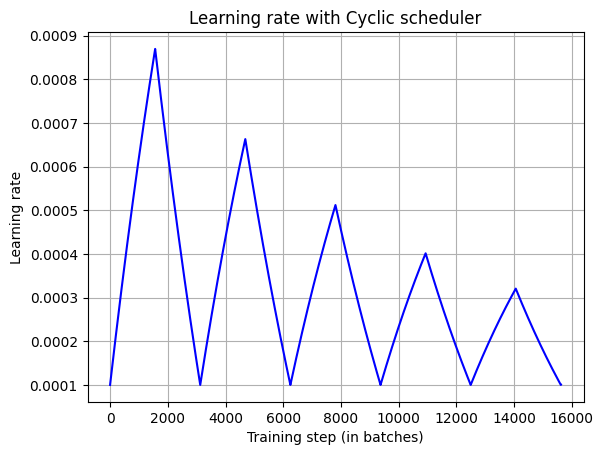

Training the model on RTX4090 took around 1 hour.

In [53]:
NUM_EPOCHS = 20

optimizer = torch.optim.Adam(translator.parameters(), lr=0.001, betas=(0.9, 0.98), eps=10e-9)

total_num_steps = NUM_EPOCHS * int(len(train_data) / batch_size)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 0.0001, 0.002, int(total_num_steps * 0.2),
                                              mode="exp_range", gamma=0.9997, cycle_momentum=False)

translator.train()

model_name = f"translator_transformer_v4_{num_layers}_layers"
best_val_loss = float("inf")
train_losses, valid_losses, all_losses = [], [], []
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    epoch_losses = train_one_epoch(translator, optimizer,
                                 loss_function, train_data_loader, device,
                                 scheduler=scheduler)

    epoch_loss = sum(epoch_losses) / len(epoch_losses)

    time_passed_seconds = time.time() - time_start

    train_losses.append(epoch_loss)
    all_losses += epoch_losses

    valid_loss = evaluate_model(model=translator, data_loader=valid_data_loader, loss_function=loss_function, device=device)
    valid_losses.append(valid_loss)

    if valid_loss < best_val_loss:
        # save best validaiton loss model
        best_val_loss = valid_loss
        print("Saving model state...")
        torch.save(translator.state_dict(), f"{PARENT_DIR}/models/{model_name}_bestval.pt")

    # save model
    torch.save(translator.state_dict(), f"{PARENT_DIR}/models/{model_name}.pt")

    print(f"Epoch: {epoch + 1}, elapsed: {time_passed_seconds:.0f} sec, train loss: {epoch_loss:.4f}, validation loss: {valid_loss:.4f}")

    if (epoch + 1) % 10 == 0:
        random_eval_idx = int(np.random.choice(list(range(len(train_data)))))
        print_sentences(data=train_data, idx=random_eval_idx, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)

    print("-" * 100)

lr: 0.0008 Running loss after 3200 batches: 4.48: 100%|██████████| 3221/3221 [00:39<00:00, 82.07it/s]


Saving model state...
Epoch: 1, elapsed: 39 sec, train loss: 4.4749, validation loss: 3.4607
----------------------------------------------------------------------------------------------------


lr: 0.0015 Running loss after 3200 batches: 3.32: 100%|██████████| 3221/3221 [00:39<00:00, 82.01it/s]


Saving model state...
Epoch: 2, elapsed: 39 sec, train loss: 3.3171, validation loss: 3.0374
----------------------------------------------------------------------------------------------------


lr: 0.0008 Running loss after 3200 batches: 2.95: 100%|██████████| 3221/3221 [00:39<00:00, 82.16it/s]


Saving model state...
Epoch: 3, elapsed: 39 sec, train loss: 2.9496, validation loss: 2.5940
----------------------------------------------------------------------------------------------------


lr: 0.0001 Running loss after 3200 batches: 2.56: 100%|██████████| 3221/3221 [00:38<00:00, 82.77it/s]


Saving model state...
Epoch: 4, elapsed: 39 sec, train loss: 2.5632, validation loss: 2.3403
----------------------------------------------------------------------------------------------------


lr: 0.0004 Running loss after 3200 batches: 2.40: 100%|██████████| 3221/3221 [00:38<00:00, 83.11it/s]


Epoch: 5, elapsed: 39 sec, train loss: 2.3971, validation loss: 2.3523
----------------------------------------------------------------------------------------------------


lr: 0.0008 Running loss after 3200 batches: 2.47: 100%|██████████| 3221/3221 [00:39<00:00, 80.78it/s]


Epoch: 6, elapsed: 40 sec, train loss: 2.4747, validation loss: 2.3948
----------------------------------------------------------------------------------------------------


lr: 0.0005 Running loss after 3200 batches: 2.45: 100%|██████████| 3221/3221 [00:39<00:00, 82.16it/s]


Saving model state...
Epoch: 7, elapsed: 39 sec, train loss: 2.4548, validation loss: 2.2604
----------------------------------------------------------------------------------------------------


lr: 0.0001 Running loss after 3200 batches: 2.28: 100%|██████████| 3221/3221 [00:39<00:00, 80.83it/s]


Saving model state...
Epoch: 8, elapsed: 40 sec, train loss: 2.2825, validation loss: 2.1519
----------------------------------------------------------------------------------------------------


lr: 0.0003 Running loss after 3200 batches: 2.19: 100%|██████████| 3221/3221 [00:38<00:00, 82.95it/s]


Epoch: 9, elapsed: 39 sec, train loss: 2.1950, validation loss: 2.1686
----------------------------------------------------------------------------------------------------


lr: 0.0004 Running loss after 3200 batches: 2.24: 100%|██████████| 3221/3221 [00:39<00:00, 82.29it/s]


Epoch: 10, elapsed: 39 sec, train loss: 2.2414, validation loss: 2.1854
SOURCE: die menschen trauen sich nicht mehr, nach ihrem eigenen urteil zu handeln.
TARGET: people no longer feel free to act on their best judgment.
MODEL: people don longer dar like to act on their own part. <EOS>.
----------------------------------------------------------------------------------------------------


lr: 0.0003 Running loss after 3200 batches: 2.24: 100%|██████████| 3221/3221 [00:39<00:00, 81.74it/s]


Saving model state...
Epoch: 11, elapsed: 39 sec, train loss: 2.2398, validation loss: 2.1454
----------------------------------------------------------------------------------------------------


lr: 0.0001 Running loss after 3200 batches: 2.15: 100%|██████████| 3221/3221 [00:39<00:00, 82.09it/s]


Saving model state...
Epoch: 12, elapsed: 39 sec, train loss: 2.1515, validation loss: 2.0820
----------------------------------------------------------------------------------------------------


lr: 0.0002 Running loss after 3200 batches: 2.10: 100%|██████████| 3221/3221 [00:38<00:00, 84.58it/s]


Epoch: 13, elapsed: 38 sec, train loss: 2.1036, validation loss: 2.0977
----------------------------------------------------------------------------------------------------


lr: 0.0003 Running loss after 3200 batches: 2.13: 100%|██████████| 3221/3221 [00:38<00:00, 82.91it/s]


Epoch: 14, elapsed: 39 sec, train loss: 2.1278, validation loss: 2.1046
----------------------------------------------------------------------------------------------------


lr: 0.0002 Running loss after 3200 batches: 2.13: 100%|██████████| 3221/3221 [00:38<00:00, 82.79it/s]


Saving model state...
Epoch: 15, elapsed: 39 sec, train loss: 2.1281, validation loss: 2.0745
----------------------------------------------------------------------------------------------------


lr: 0.0001 Running loss after 3200 batches: 2.08: 100%|██████████| 3221/3221 [00:39<00:00, 82.18it/s]


Saving model state...
Epoch: 16, elapsed: 39 sec, train loss: 2.0809, validation loss: 2.0469
----------------------------------------------------------------------------------------------------


lr: 0.0001 Running loss after 3200 batches: 2.05: 100%|██████████| 3221/3221 [00:39<00:00, 82.33it/s]


Saving model state...
Epoch: 17, elapsed: 39 sec, train loss: 2.0545, validation loss: 2.0445
----------------------------------------------------------------------------------------------------


lr: 0.0002 Running loss after 3200 batches: 2.07: 100%|██████████| 3221/3221 [00:38<00:00, 83.36it/s]


Epoch: 18, elapsed: 39 sec, train loss: 2.0659, validation loss: 2.0588
----------------------------------------------------------------------------------------------------


lr: 0.0001 Running loss after 3200 batches: 2.07: 100%|██████████| 3221/3221 [00:39<00:00, 82.34it/s]


Saving model state...
Epoch: 19, elapsed: 39 sec, train loss: 2.0656, validation loss: 2.0404
----------------------------------------------------------------------------------------------------


lr: 0.0001 Running loss after 3200 batches: 2.04: 100%|██████████| 3221/3221 [00:39<00:00, 82.41it/s]


Saving model state...
Epoch: 20, elapsed: 39 sec, train loss: 2.0403, validation loss: 2.0274
SOURCE: und die mellon bank ist ein mieter.
TARGET: and mellon bank ' s a tenant.
MODEL: and mellon bank is s a renure. <EOS> ren
----------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Average loss per epoch')

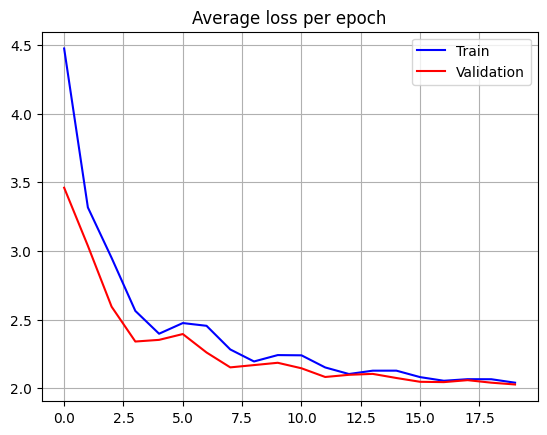

In [54]:
plt.plot(train_losses, color="blue", label="Train")
plt.plot(valid_losses, color="red", label="Validation")
plt.legend()
plt.grid()
plt.title("Average loss per epoch")

### Evaluate

In [24]:
translator.load_state_dict(torch.load(f"{PARENT_DIR}/models/{model_name}_bestval.pt", map_location=device))
translator.eval()

/var/folders/4s/mv0mfx752sb76dmyd9_tr18w0000gn/T/ipykernel_62249/1683440986.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  translator.load_state_dict(torch.load(f"{PARE

TranslatorModel(
  (encoder): Encoder(
    (token_embedding): Embedding(8000, 256)
    (positional_embedding): Embedding(128, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (ff): PositionWiseFeedForward(
          (fc_1): Linear(in_features=256, out_features=1024, bias=True)
          (fc_2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (mha): MultiHeadAttention(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (out): Linear(in_features=256, out_features=256, bias=True)
          (d

Let's evaluate how our model translates sentences from the training set.

In [26]:
random_eval_idx = int(np.random.choice(list(range(len(train_data)))))
print_sentences(data=train_data, idx=random_eval_idx, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)

SOURCE: ich habe eine minute. mein ted wunsch ist also : ich wünsche mir dass ihr -- ihr persönlich und jedes kreative individuum und organisation die ihr kennt -- einen weg findet euch direkt mit einer öffentlichen schule in eurer umgebung zu engagieren und dass ihr dann die geschichte davon erzählt wie ihr involviert wurdet so dass wir innerhalb eines jahres tausend beispiele haben -- ein tausend! -- von transformierenden partnerschaften.
TARGET: all right, i ' ve got a minute. so, the ted wish : i wish that you -- you personally and every creative individual and organization you know -- will find a way to directly engage with a public school in your area and that you ' ll then tell the story of how you got involved, so that within a year we have a thousand examples -- a thousand! -- of transformative partnerships.
MODEL: so i, i have ve got a minute. my my my ted wish is i wish you you -- your personally and every creative individual and organization that know -- you find a way 

In [27]:
idxs = [43, 420, 13, 6, 999]

for idx in idxs:
    print_sentences(data=train_data, idx=idx, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)
    print("-" * 100)

SOURCE: ich füge neue bilder hinzu, weil ich jedes mal wieder etwas dazulerne. wie beim strandgutsammeln -- jedes mal, wenn die flut da war,
TARGET: i add new images, because i learn more about it every time i give it. it ' s like beach - combing, you know?
MODEL: i add new images, because i ' a about it every time, ' you a <EOS> was s like thees gatherining. every know, <EOS> flu
----------------------------------------------------------------------------------------------------
SOURCE: und damals war der mars noch viel interessanter als heute. wir dachten, da würde es tiere geben, und wir waren sicher, dass es pflanzen gab, weil sich ja die farben änderten.
TARGET: and this was at a time when mars was a hell of a lot more interesting than it is now. we thought there ' d be animals there ; we knew there were plants there ; the colors change, right?
MODEL: and then was the the time mars mars was much lot of a lot more interesting than today was,, we thought there were d be animals,,

Now let's give it our own sentences.

In [28]:
translate(model=translator,
          src="Hallo Welt, wie geht es?",
          src_lang=src_lang,
          tgt_lang=tgt_lang,
          max_tgt_length=100,
          device=device)

'<BOS> hello world, how is it going? <EOS>'

It looks like it is pretty good at translating simple short sentences :)

In [44]:
bleu = evaluate.load("bleu")

def get_tokenizer_fn(tgt_tokenizer: Tokenizer):
    def tokenizer_fn(s):
        tokens = tgt_tokenizer.encode(s).tokens
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(tgt_lang)

In [45]:
# compute BLEU metric on test data
predictions, references = [], []
for idx in tqdm(range(test_data.num_rows)):
    data_eval_src = test_data[idx]["de_ids"].reshape(1, -1).to(device)
    sentence_evaluated = translate(model=translator,
                                   src=data_eval_src,
                                   src_lang=src_lang,
                                   tgt_lang=tgt_lang,
                                   max_tgt_length=max_length,
                                   device=device,
                                   clean=True)


    predictions.append(sentence_evaluated)
    references.append(test_data[idx]["translation"]["en"])

bleu.compute(predictions=predictions, references=references, tokenizer=tokenizer_fn)

100%|██████████| 8079/8079 [02:22<00:00, 56.71it/s]


{'bleu': 0.3015401110887998,
 'precisions': [0.6589879555851704,
  0.4061990499090962,
  0.25167609631166465,
  0.16680703845755157],
 'brevity_penalty': 0.9261405723703616,
 'length_ratio': 0.9287385850685416,
 'translation_length': 178589,
 'reference_length': 192292}

### Export to ONNX

In [34]:
model_src = torch.randint(src_lang.get_vocab_size(), size=(1, max_length))
model_tgt = torch.randint(tgt_lang.get_vocab_size(), size=(1, max_length))
onnx_program = torch.onnx.dynamo_export(translator, model_src, model_tgt)

/Users/nivanov/miniconda3/envs/dlmetal/lib/python3.11/site-packages/torch/onnx/_internal/exporter.py:137: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


Applied 41 of general pattern rewrite rules.


In [35]:
onnx_program.save(f"{PARENT_DIR}/models/{model_name}.onnx")